<a href="https://colab.research.google.com/github/wessware/pytorch-101/blob/main/linear_regression_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch
import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [37]:
df = pd.read_csv('/content/sample_data/sales_data.csv', index_col=None)

In [38]:
df.shape

(7991, 12)

In [39]:
df.head()

,OrderNumber,OrderDate,WarehouseCode,Sales Channel,StoreID,SalesTeamID,CustomerID,ProductID,Order_Quantity,Discount_Applied,Unit_Price,Unit_Cost
0,SO - 000101,5/31/2018,WARE-UHY1004,1,259,6,15,12,5,0.075,1963.1,1001.18
1,SO - 000102,5/31/2018,WARE-NMK1003,2,196,14,20,27,3,0.075,3939.6,3348.66
2,SO - 000103,5/31/2018,WARE-UHY1004,3,213,21,16,16,1,0.050,1775.5,781.22
3,SO - 000104,5/31/2018,WARE-NMK1003,4,107,28,48,23,8,0.075,2324.9,1464.69
4,SO - 000105,5/31/2018,WARE-NMK1003,3,111,22,49,26,8,0.100,1822.4,1476.14


In [40]:
df.columns

Index(['OrderNumber', 'OrderDate', 'WarehouseCode', 'Sales Channel', 'StoreID',
       'SalesTeamID', 'CustomerID', 'ProductID', 'Order_Quantity',
       'Discount_Applied', 'Unit_Price', 'Unit_Cost'],
      dtype='object')

In [41]:
df = df[['Sales Channel', 'StoreID', 'SalesTeamID', 'CustomerID', 'ProductID', 'Order_Quantity', 'Discount_Applied',
         'Unit_Price', 'Unit_Cost']]

In [42]:
df.columns

Index(['Sales Channel', 'StoreID', 'SalesTeamID', 'CustomerID', 'ProductID',
       'Order_Quantity', 'Discount_Applied', 'Unit_Price', 'Unit_Cost'],
      dtype='object')

In [43]:
df.isnull().sum()

Sales Channel       0
StoreID             0
SalesTeamID         0
CustomerID          0
ProductID           0
Order_Quantity      0
Discount_Applied    0
Unit_Price          0
Unit_Cost           0
dtype: int64

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7991 entries, 0 to 7990
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Sales Channel     7991 non-null   int64  
 1   StoreID           7991 non-null   int64  
 2   SalesTeamID       7991 non-null   int64  
 3   CustomerID        7991 non-null   int64  
 4   ProductID         7991 non-null   int64  
 5   Order_Quantity    7991 non-null   int64  
 6   Discount_Applied  7991 non-null   float64
 7   Unit_Price        7991 non-null   float64
 8   Unit_Cost         7991 non-null   float64
dtypes: float64(3), int64(6)
memory usage: 562.0 KB


In [45]:
df.index

RangeIndex(start=0, stop=7991, step=1)

In [46]:
x_cols = ['Sales Channel', 'StoreID', 'SalesTeamID', 'CustomerID', 'ProductID', 'Discount_Applied',
         'Unit_Price', 'Unit_Cost']

In [47]:
x = df[x_cols].values
y = df['Order_Quantity'].values

In [49]:
x_train_, x_test_, y_train, y_test = train_test_split(x, y, train_size=0.7, shuffle=True)

In [50]:
scaler = StandardScaler()

scaler.fit(x_train_)

x_train = scaler.transform(x_train_)
x_test = scaler.transform(x_test_)

In [51]:
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).reshape(-1, 1)

x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).reshape(-1, 1)

In [52]:
lr_model = nn.Sequential(
    nn.Linear(8, 24), nn.ReLU(),
    nn.Linear(24, 12), nn.ReLU(),
    nn.Linear(12, 6), nn.ReLU(),
    nn.Linear(6, 1)
)

In [53]:
loss_fn = nn.MSELoss()  

optimizer = optim.Adam(lr_model.parameters(), lr=0.0001)

In [54]:
n_epochs = 100   
batch_size = 10 

batch_start = torch.arange(0, len(x_train), batch_size)

In [55]:
best_mse = np.inf   
best_weights = None
history = []

In [57]:
for epoch in range(n_epochs):

    lr_model.train()

    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")

        for start in bar:

            # selecting a batch
            x_batch = x_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]

            # forward iterate
            y_pred = lr_model(x_batch)
            loss = loss_fn(y_pred, y_batch)

            # backward iterate
            optimizer.zero_grad()
            loss.backward()

            # update weights
            optimizer.step()

            # verbosity check
            bar.set_postfix(mse=float(loss))

In [60]:
# evaluating model accuracy at end of each epoch
lr_model.eval()

y_pred = lr_model(x_test)

mse = loss_fn(y_pred, y_test)
mse = float(mse)

history.append(mse)

if mse < best_mse:
  best_mse = mse
  best_weights = copy.deepcopy(lr_model.state_dict())

MSE: 5.34
RMSE: 2.31


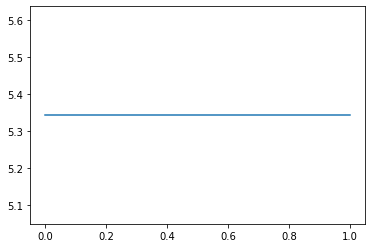

In [61]:
lr_model.load_state_dict(best_weights)

print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))

plt.plot(history)
plt.show()
 